## Vision por computadora 1 - FIUBA
## 17Co2024
## Autores: Joaquín Matías Mestanza, Gonzalo Nicolas Silva Caggiano, Ramiro Andrés Feichubuinm

Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image
Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:
    1. Medición sobre todo el frame.
    2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
    3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
    arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)
    Para cada experimento se debe presentar :
    - Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto
    de máximo enfoque.
    - Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
    donde se detecta la condición de máximo enfoque.


### Implementación

In [1]:
import numpy as np
from numpy.fft import fftshift, fft2
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
def image_quality_measure(gray_img):
    m, n = gray_img.shape
    F = fft2(gray_img)
    Fc = fftshift(F)
    AF = np.abs(Fc)
    M = np.max(AF)
    thres = M/1000
    Th = np.sum(AF > thres)
    return Th/(m*n)

### Verificación

In [3]:
from utils import get_gray_img                       
lena_gray = get_gray_img(cv2.imread('lena.png'))
lena_gray.shape

(512, 512)

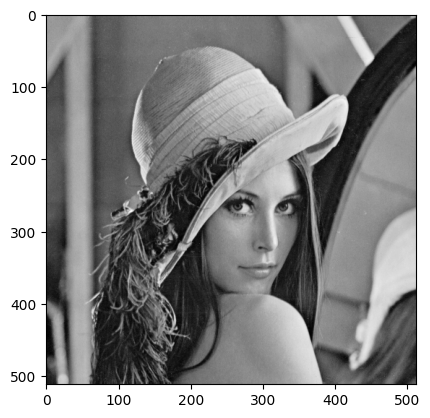

In [4]:
plt.imshow(lena_gray, cmap='gray')

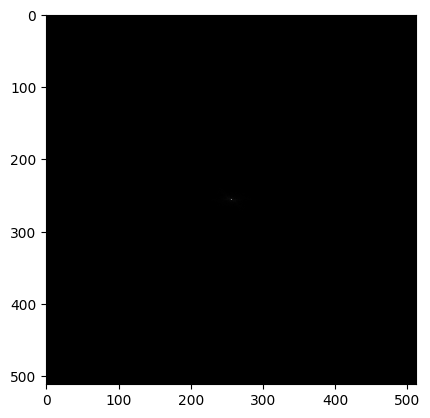

In [5]:
spectrum = np.abs(fftshift(fft2(lena_gray)))
plt.imshow(spectrum, cmap='gray')

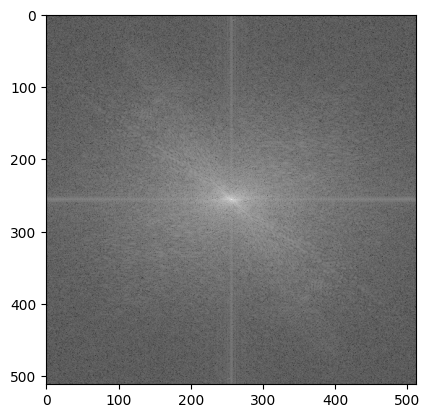

In [6]:
plt.imshow(np.log2(1+abs(spectrum)), cmap='gray')

In [7]:
image_quality_measure(lena_gray)

np.float64(0.018215179443359375)

Este valor coincide con el del trabajo publicado, es decir que el algoritmo se encuentra implementado correctamente.
Sin embargo, se ve que cuando se quiere realizar la estimación del espectro, es distinta a la que se muestra en el paper. Esto puede ser debido a que se utilizó otra imagen de lena (podría ser de menor dimensión) o se realizó una estimación espectral con algun tipo de filtro adicional. 

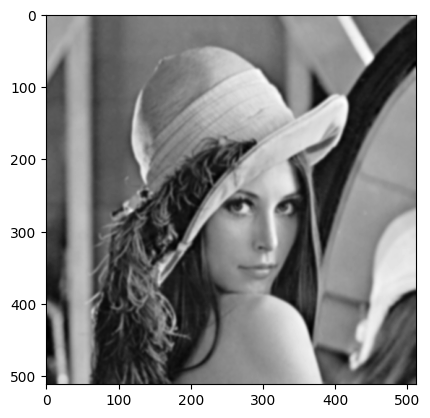

In [8]:
filtered_image = cv2.GaussianBlur(lena_gray, (7,7), 0)
plt.imshow(filtered_image, cmap='gray')

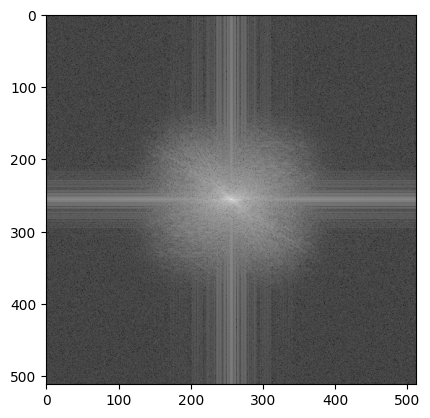

In [9]:
plt.imshow(np.log(1+np.abs(fftshift(fft2(filtered_image)))), cmap='gray')

In [10]:
image_quality_measure(filtered_image)

np.float64(0.013317108154296875)

Aquí se ve que cuando se aplica un GaussianBlur, la métrica disminuye, lo cual también es un comportamiento esperado.

### 1.1. Medición sobre todo el frame.

In [11]:
video = cv2.VideoCapture('focus_video.MOV')
fps = round(video.get(cv2.CAP_PROP_FPS))
# video.read()

In [12]:
from utils import read_video_and_store_frames
fps = read_video_and_store_frames('focus_video.MOV')

Frames folders already created.
Storing video frames...
Frames stored successfully


In [13]:
frame_paths = list(map(lambda x: f'frames/{x}', sorted(os.listdir('frames'))))
frame_paths[:5] # muestra los primeros 5

['frames/frame-000.jpg',
 'frames/frame-001.jpg',
 'frames/frame-002.jpg',
 'frames/frame-003.jpg',
 'frames/frame-004.jpg']

In [14]:
metrics = [image_quality_measure(cv2.cvtColor(cv2.imread(frame), cv2.COLOR_BGR2GRAY)) for frame in frame_paths]

1. Medición sobre todo el frame

In [15]:
from utils import plot_metric

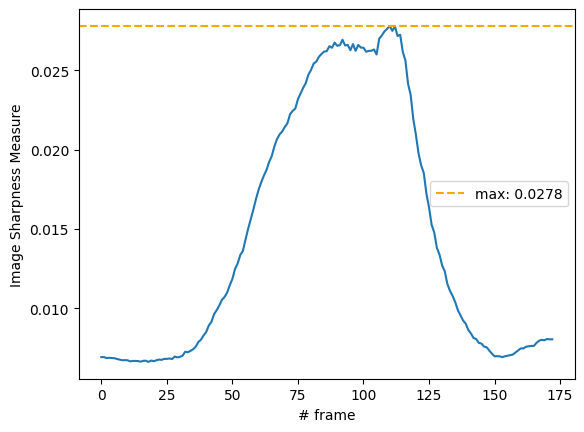

In [16]:
iqm_max = plot_metric(metrics)

 2. Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del área total del frame.

In [17]:
from utils import get_metric_for_centered_roi
metrics_roi_5_percent = [get_metric_for_centered_roi(frame, image_quality_measure, 0.05) for frame in frame_paths]

np.float64(0.96875)

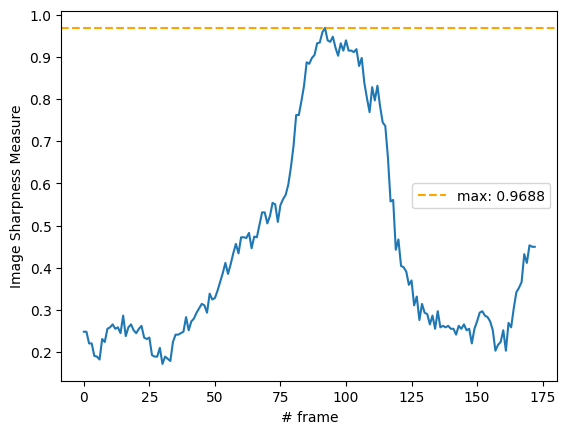

In [18]:
plot_metric(metrics_roi_5_percent)

La razón por la que cambió la métrica es porque el roi de 5% es parte del objeto.

Cuando realizamos la medición sobre toda la imagen, es posible que en algunos momentos el fondo esté desenfocado y el objeto también, o que el objeto esté enfocado y el fondo no.

Si nuestro objetivo es detectar el enfoque del objeto, entonces nos conviene esta configuración.

In [19]:
metrics_roi_10_percent = [get_metric_for_centered_roi(frame, image_quality_measure, 0.10) for frame in frame_paths]

np.float64(0.7491319444444444)

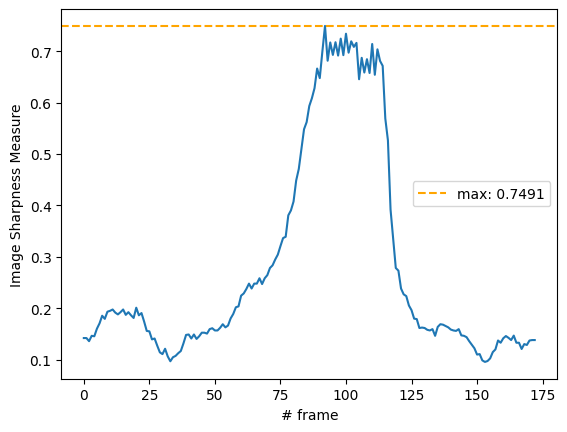

In [20]:
plot_metric(metrics_roi_10_percent)

3. Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores
    arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

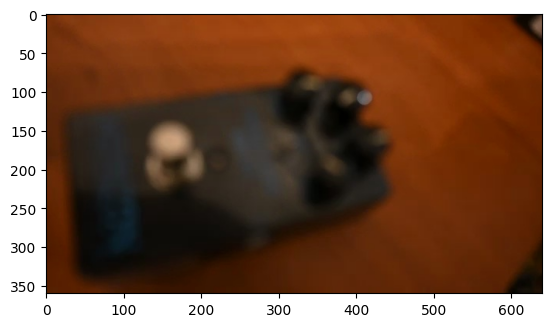

In [21]:
from utils import bgr_to_rgb
original = bgr_to_rgb(frame_paths[0])
plt.imshow(original)

In [22]:
from utils import get_focus_matrix
    

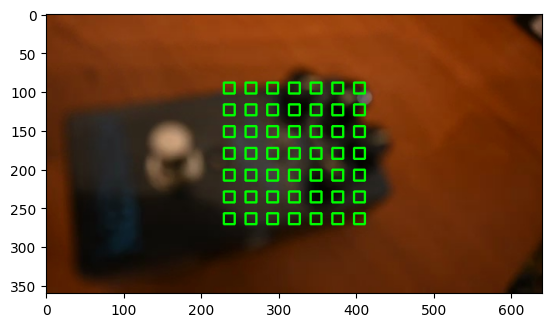

In [23]:
modified_7x7, points_7x7 = get_focus_matrix(original, rects_i=7, rects_j=7, dj=7, di=7)
plt.imshow(modified_7x7)

Se verifica que tiene un comportamiento similar a la imagen en la consigna

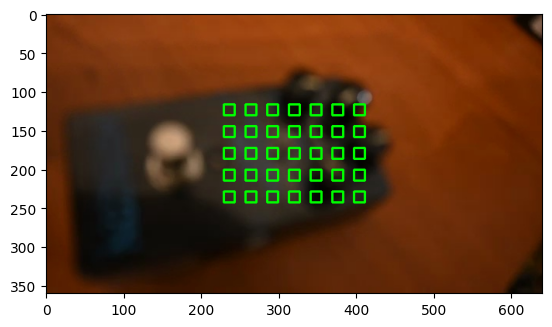

In [24]:
modified_5x7, points_5x7 = get_focus_matrix(original, rects_i=5, rects_j=7, dj=7, di=7)
plt.imshow(modified_5x7)

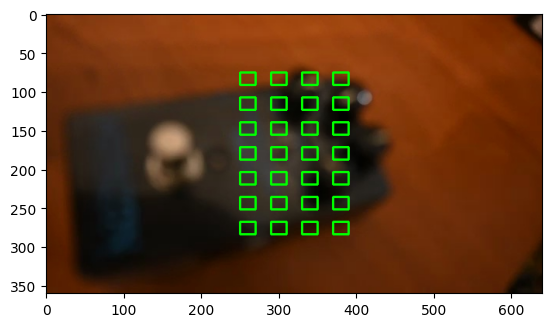

In [25]:
modified_7x4, points_7x4 = get_focus_matrix(original, rects_i=7, rects_j=4, dj=10, di=8)
plt.imshow(modified_7x4)

Ahora que los puntos están definidos, se debe definir un criterio sobre como agrupar por frame los distintos Image Quality Measure obtenidos. 

En este caso, optamos por el promedio ya que minimo y maximo dieron resultados muy ruidosos y dificiles de interpretar.

In [26]:
from utils import group_metric

In [27]:
metrics_7x7 = [group_metric(cv2.imread(frame), points_7x7, image_quality_measure, np.mean) for frame in frame_paths]

np.float64(0.9029571012078301)

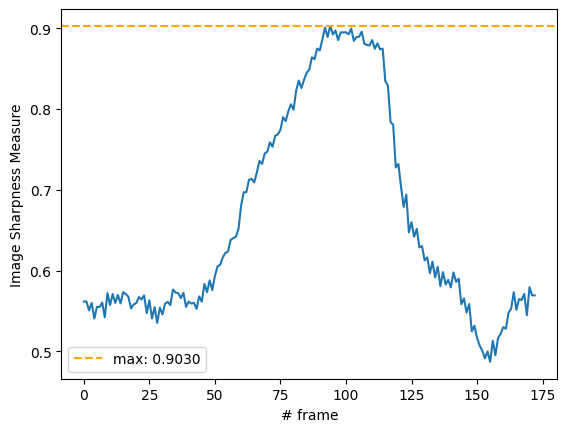

In [28]:
plot_metric(metrics_7x7)

In [29]:
metrics_5x7 = [group_metric(cv2.imread(frame), points_5x7, image_quality_measure, np.mean) for frame in frame_paths]

np.float64(0.9568513119533528)

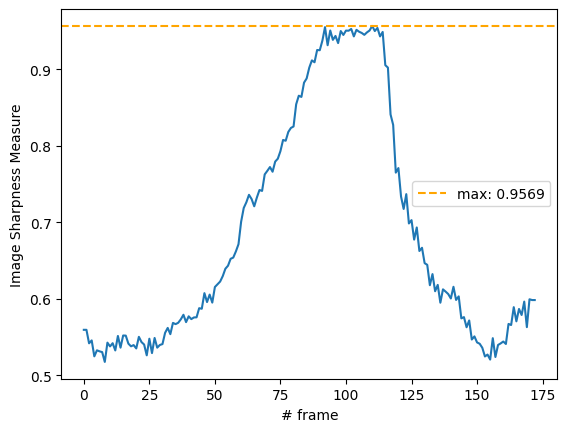

In [30]:
plot_metric(metrics_5x7)

In [31]:
metrics_7x4 = [group_metric(cv2.imread(frame), points_7x4, image_quality_measure, np.mean) for frame in frame_paths]

np.float64(0.8437500000000001)

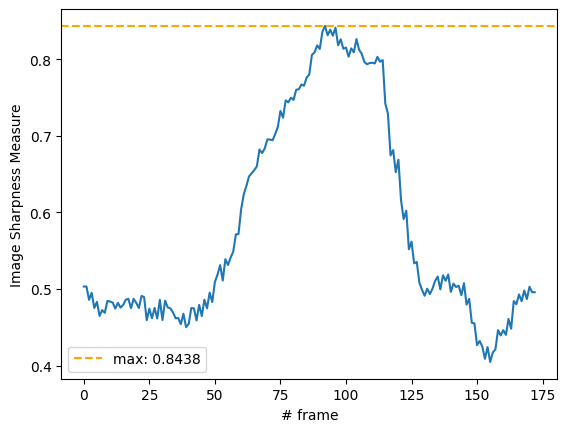

In [32]:
plot_metric(metrics_7x4)

In [33]:
from utils import draw_focus_matrix

In [34]:
print(iqm_max)

0.027782118055555555


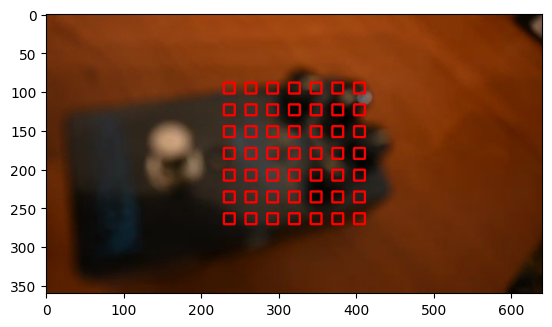

In [35]:
focused_imgs_7x7 = [draw_focus_matrix(frame, 0.7, points_7x7, image_quality_measure) for frame in frame_paths]
plt.imshow(focused_imgs_7x7[0])

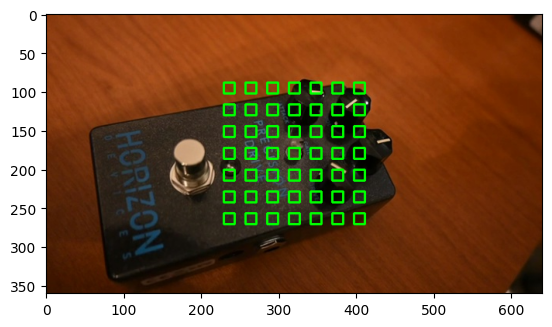

In [36]:
plt.imshow(focused_imgs_7x7[100])

In [37]:
from utils import write_video
write_video(filename='output_7x7.mp4',rgb_frames=focused_imgs_7x7, fps=fps) 

### 2.

#### Brenners focus measure

In [38]:
def brenner_focus_measure(gray_img):
    shifted_img = np.roll(gray_img, 2, axis=1)
    diff = gray_img - shifted_img
    brenner_measure = np.sum(diff**2)
    return brenner_measure / gray_img.size


In [39]:
metrics_7x7_brenner = [group_metric(cv2.imread(frame), points_7x7,brenner_focus_measure, np.mean) for frame in frame_paths]

np.float64(41.432319866722196)

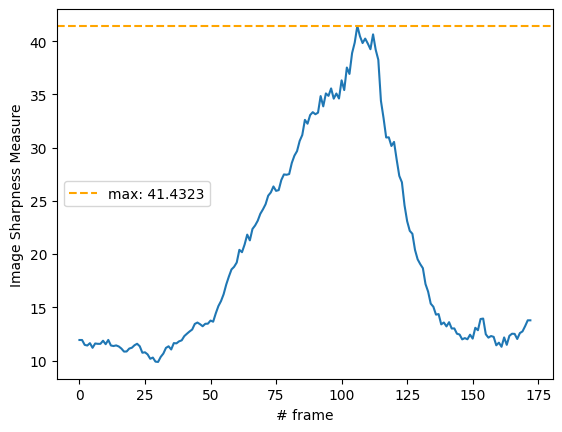

In [40]:
plot_metric(metrics_7x7_brenner)


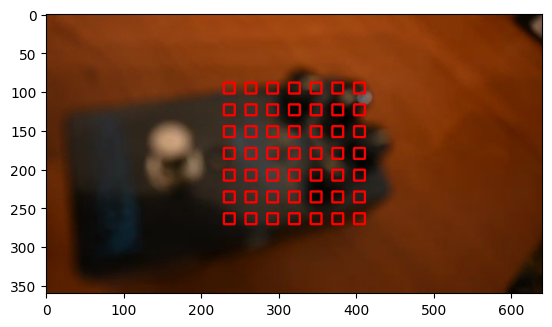

In [41]:
brenner_focus_image = [draw_focus_matrix(frame, 0.7 * np.max(metrics_7x7_brenner), points_7x7,brenner_focus_measure) for frame in frame_paths]
plt.imshow(brenner_focus_image[0])

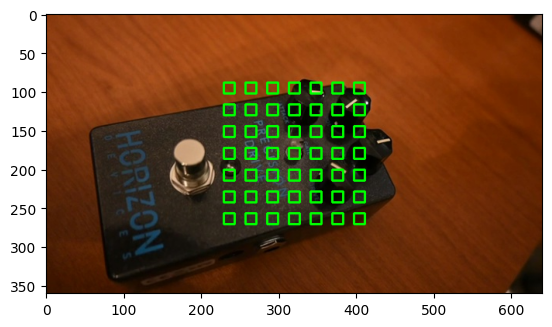

In [42]:
plt.imshow(brenner_focus_image[100])

In [43]:
write_video('output_brenner.mp4', brenner_focus_image, fps) 

#### Spacial frecuency measure

In [44]:
def spatial_frequency(image):
    Ix = np.diff(image, axis=1)
    Iy = np.diff(image, axis=0)
    return np.sqrt(np.sum(Ix ** 2) + np.sum(Iy ** 2))

np.float64(90.40073467663193)

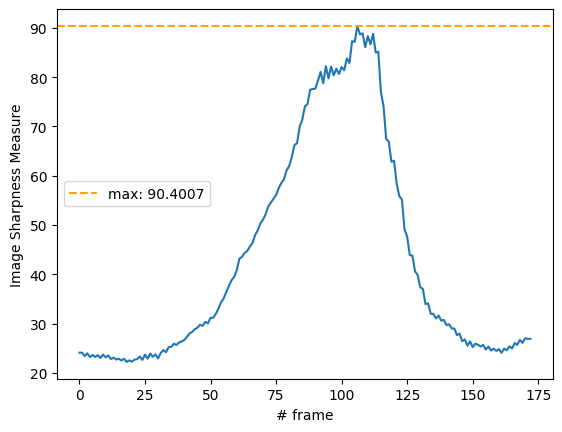

In [45]:
metrics_7x7_sf = [group_metric(cv2.imread(frame), points_7x7, spatial_frequency, np.mean) for frame in frame_paths]
plot_metric(metrics_7x7_sf)

In [46]:
sf_focus_image = [draw_focus_matrix(frame, 0.7 * np.max(metrics_7x7_sf), points_7x7, spatial_frequency) for frame in frame_paths]

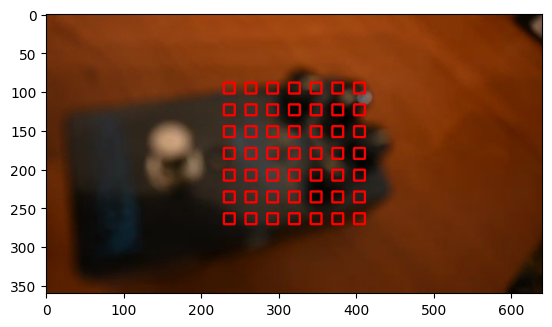

In [47]:
plt.imshow(sf_focus_image[0])

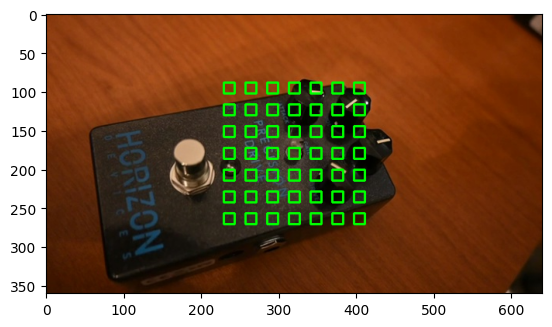

In [48]:
plt.imshow(sf_focus_image[100])

In [49]:
write_video('output_sf.mp4', sf_focus_image, fps) 